In [2]:
from pyopenms import *
import numpy as np
import glob
import pandas as pd
import sys
import datashader as ds 
import holoviews as hv
import panel as pn
import holoviews.operation.datashader as hd
from holoviews.plotting.util import process_cmap
from holoviews import opts, dim
hv.extension('bokeh', logo= False)

### Interactive plot to compare pre-processed and re-quantified data

In [2]:
fmap = FeatureMap() 
loader = FeatureXMLFile()
loadopts = loader.getOptions()  
loadopts.setIntensityRange(DRange1(DPosition1(5000), DPosition1(sys.maxsize)))
loader.setOptions(loadopts)
loader.load('results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML', fmap)
fmap.updateRanges()
expandcols = ["RT", "mz", "inty"]
spectraarrs2d = ([f.getRT() for f in fmap], [f.getMZ() for f in fmap], [f.getIntensity() for f in fmap]) 
spectradf = pd.DataFrame(dict(zip(expandcols, spectraarrs2d)))
spectradf = spectradf.set_index(["RT","mz"])

maxrt = spectradf.index.get_level_values(0).max()
minrt = spectradf.index.get_level_values(0).min()
maxmz = spectradf.index.get_level_values(1).max()
minmz = spectradf.index.get_level_values(1).min()

def new_bounds_hook(plot, elem):
    x_range = plot.state.x_range
    y_range = plot.state.y_range
    x_range.bounds = minrt, maxrt
    y_range.bounds = minmz, maxmz

points = hv.Points(spectradf, kdims=['RT', 'mz'], vdims=['inty'], label="MS1 scans_pre-processed").opts(
    fontsize={'title': 16, 'labels': 14, 'xticks': 6, 'yticks': 12},
    color=np.log(dim('int')),
    colorbar=True,
    cmap='Magma',
    width=1000,
    height=1000,
    tools=['hover'])

raster = hd.rasterize(points, cmap=process_cmap("blues", provider="bokeh"), aggregator=ds.sum('inty'),
                    cnorm='log', alpha=10, min_alpha=0
        ).opts(
            active_tools=['box_zoom'],
            tools=['hover'],
            hooks=[new_bounds_hook]
        ).opts(  
            plot=dict(
                width=800,
                height=800,
                xlabel="Retention time (s)",
                ylabel="mass/charge (Da)"
            )
        )

hd.dynspread(raster, threshold=0.7, how="add", shape="square")
hv_plot = hv.Points(points)
hv_plot.opts(opts.Points(tools=['hover'], size=5))
hv_plot.opts(frame_width= 500, frame_height= 500)

:Points   [RT,mz]   (inty)

In [4]:
fmap = FeatureMap() 
loader = FeatureXMLFile()
loadopts = loader.getOptions()  
#loadopts.setMSLevels([1])
#loadopts.setSkipXMLChecks(True)
#loadopts.setIntensity32Bit(True)
loadopts.setIntensityRange(DRange1(DPosition1(5000), DPosition1(sys.maxsize)))
loader.setOptions(loadopts)
loader.load('results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML', fmap)
fmap.updateRanges()
expandcols = ["RT", "mz", "inty"]
spectraarrs2d= (np.fromiter((f.getRT() for f in fmap), dtype='f'), np.fromiter((f.getMZ() for f in fmap), dtype='f'), np.fromiter((f.getIntensity() for f in fmap), dtype='i'))
spectradf = pd.DataFrame(dict(zip(expandcols, spectraarrs2d)))
spectradf = spectradf.set_index(["RT","mz"])

maxrt = spectradf.index.get_level_values(0).max()
minrt = spectradf.index.get_level_values(0).min()
maxmz = spectradf.index.get_level_values(1).max()
minmz = spectradf.index.get_level_values(1).min()

def new_bounds_hook(plot, elem):
    x_range = plot.state.x_range
    y_range = plot.state.y_range
    x_range.bounds = minrt, maxrt
    y_range.bounds = minmz, maxmz

points = hv.Points(spectradf, kdims=['RT', 'mz'], vdims=['inty'], label="MS1_re-quantified").opts(
    fontsize={'title': 16, 'labels': 14, 'xticks': 6, 'yticks': 12},
    color=np.log(dim('int')),
    colorbar=True,
    cmap='Magma',
    width=1000,
    height=1000,
    tools=['hover'])

raster = hd.rasterize(points, cmap=process_cmap("blues", provider="bokeh"), aggregator=ds.sum('inty'),
                    cnorm='log', alpha=10, min_alpha=0
        ).opts(
            active_tools=['box_zoom'],
            tools=['hover'],
            hooks=[new_bounds_hook]
        ).opts(  # weird.. I have no idea why one has to do this. But with one opts you will get an error
            plot=dict(
                width=800,
                height=800,
                xlabel="Retention time (s)",
                ylabel="mass/charge (Da)"
            )
        )

hd.dynspread(raster, threshold=0.7, how="add", shape="square")
hv_plot = hv.Points(points)
hv_plot.opts(opts.Points(tools=['hover'], size=5))
hv_plot.opts(frame_width= 500, frame_height= 500)

:Points   [RT,mz]   (inty)

Visualise the FFMIdent identifications (quite useless when you have a lot of features - aka very complex samples). Better for targeted metabolomics

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

path= sorted(glob.glob('results/Requant/interim/*.featureXML'))

def plotDetectedFeatures3D(filename):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(filename, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()
    
for filename in path:
    print(filename)
    plotDetectedFeatures3D(filename)

### Create diagnostic plots (check the frequency of the presence of a feature with histograms):

In [169]:
import numpy as np
import pandas as pd

df= pd.read_csv("results/Requant/FeatureMatrix.tsv", sep="\t")
df= df.drop(columns="charge")
df= df.sort_index(axis=1)


,mz,DNPM_Plate-2_MDNAWGS14_blank,DNPM_Plate-2_MDNAWGS14_rep1,DNPM_Plate-2_MDNAWGS14_rep2,DNPM_Plate-2_MDNAWGS14_rep3,FPY12_Plate-2_MDNAWGS14_blank,FPY12_Plate-2_MDNAWGS14_rep1,FPY12_Plate-2_MDNAWGS14_rep2,FPY12_Plate-2_MDNAWGS14_rep3,ISP2_Plate-2_MDNAWGS14_blank,ISP2_Plate-2_MDNAWGS14_rep1,ISP2_Plate-2_MDNAWGS14_rep2,ISP2_Plate-2_MDNAWGS14_rep3
0,489.25494,652974.2,256839.50,151520.20,79780.140,36973.93,6.282002e+05,339779.60,247363.300,156607.50,1.303168e+05,83421.750,1.387400e+05
1,396.18720,191643.6,86121.01,158938.70,118689.000,210583.50,6.506829e+05,902076.10,1102605.000,79279.17,3.297519e+04,26509.980,4.646170e+04
2,359.23950,2042334.0,38741.71,10947.06,13384.050,36551.81,1.879215e+05,117213.50,180031.000,189583.80,5.983903e+04,40146.670,3.408095e+04
3,308.17114,2365180.0,2259782.00,1784322.00,1825069.000,67544.91,4.129224e+05,45230.80,63598.060,561391.30,3.733023e+05,315790.400,3.069804e+05
4,239.13843,123069.0,913240.10,786868.00,752350.000,1438382.00,1.524618e+05,234744.90,405019.700,1170589.00,7.291768e+05,671625.100,6.423117e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,473.27576,2861345.0,32723.33,24198.16,8124.671,450449.70,5.710278e+03,27448.33,7349.538,4935874.00,6.204479e+03,6366.977,6.860216e+03
1609,199.10716,182904.0,164012.00,567507.00,141420.800,207553.70,6.128569e+04,166181.50,63494.180,404708.10,1.877687e+05,68986.310,6.769554e+04
1610,464.25974,199752.2,998531.00,721876.30,2151919.000,37919.96,1.925072e+06,2484534.00,2295987.000,145862.10,3.625197e+07,9405034.000,4.021598e+07
1611,446.22403,527184.3,155457.10,108608.00,117104.000,41633730.00,4.815788e+06,7622085.00,9758149.000,183828.60,4.474249e+04,52874.520,1.021308e+04


Visualise map alignes files (example)

In [6]:
path= "results/GNPSexport/interim/"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_feature_files = glob.glob('results/features/interim/*.featureXML')
feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_92181/4033247350.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


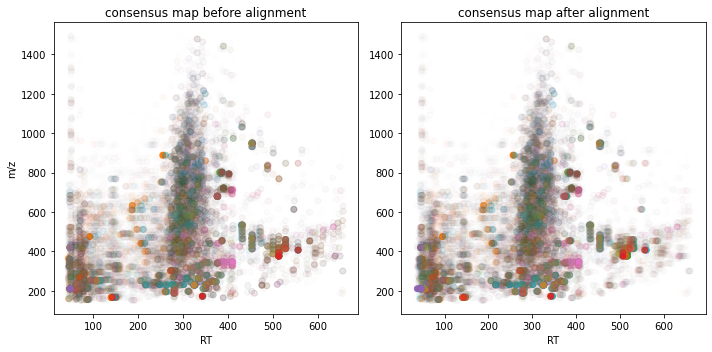

In [7]:
import matplotlib.pyplot as plt
import numpy as np

ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()

aligner_par.setValue("max_num_peaks_considered", -1)
aligner_par.setValue("superimposer:mz_pair_max_distance", 0.05)
aligner_par.setValue("pairfinder:distance_MZ:max_difference", 10.0)
aligner_par.setValue("pairfinder:distance_MZ:unit", "ppm")
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value


feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()